# wires of LN04
## Directory: /bigdata/hplsim/production/MEC_wires

In [10]:
#includes
%matplotlib notebook
#notebook
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import affine_transform
from scipy import interpolate
from scipy.ndimage import measurements
from scipy.fftpack import fft2
from scipy.fftpack import ifft2
from scipy.fftpack import fftshift
from scipy.fftpack import ifftshift
from scipy.fftpack import fftfreq
import scipy as sc
import matplotlib as mpl
from PIL import Image
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.filters import gaussian_filter as smooth
import pickle

#import happi
execfile("/home/kluget/smilei-src/scripts/Diagnostics.py")
import pint

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
from tqdm.notebook import tqdm
from multiprocess import Pool

m = 1e9
um=1e3
mm=1e6
nm=1.
keV=1
eV=1e-3

import rossendorfer_farbenliste as rofl
mpl.cm.register_cmap(cmap=rofl.cmap(),name="rofl")
def create_colors(total_color_no=100):
    return rofl.cmap_nw()(np.linspace(0,1,total_color_no))

/tmp/ipykernel_22534/2848670687.py:28: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [29]:
import glob
import tifffile as tiff
#Set data paths
runs={}
for j,i in enumerate([219,220,235,217,225,226,227,228,229,230,231,232,234,236,237]):
    paths=sorted(glob.glob(
          "/bigdata/hplsim/production/MEC_wires/run"+str(i).zfill(3)+"*"
    ))
    events = []
    for p in paths:
        events.append(tiff.imread(p))
    with suppress_stdout():
        runs[i] = events
transmissions={
    217:[
        0.01,
        0.01,
        1,
        1
    ],
    219:[
        0.01,
        0.01,
        1,
        1.       
    ],
    220:[
        1,
        0.1,
        1,
        1.
    ],
    225:[
        0.1,
        0.1,
        1,
        1
    ],
    226:[
        0.1,
        0.1,
        1,
        1
    ],
    227:[
        0.1,
        0.1,
        1,
        1
    ],
    228:[
        0.01,
        0.01,
        1,
        1
    ],
    229:[
        0.01,
        0.01,
        1,
        0.9
    ],
    230:[
        0.0012,
        0.0012,
        0.01,
        0.01,
        1,
        1
    ],
    231:[
        0.01,
        0.01,
        0.01,
        0.01
    ],
    232:[
        0.1,
        0.1,
        1,
        1
    ],
    234:[
        0.1,
        0.1,
        1,
        1
    ],
    235:[
        0.1,
        0.1,
        1,
        1
    ],
    236:[
        0.0012,
        0.01,
        0.01,
        1,
        1
    ],
    237:[
        0.01,
        0.01,
        1,
        1
    ],   
}
delay={
    217:40,219:0,220:10,225:40,226:40,227:41,228:41,229:80,230:41,231:41,232:41,234:21,235:20,236:41,237:5
}
intensity={
    217:1,219:1,220:1,225:0.5,226:0.75,227:1,228:1,229:1,230:1,231:1,232:.75,234:1,235:1,236:1,237:1
}

<IPython.core.display.Javascript object>


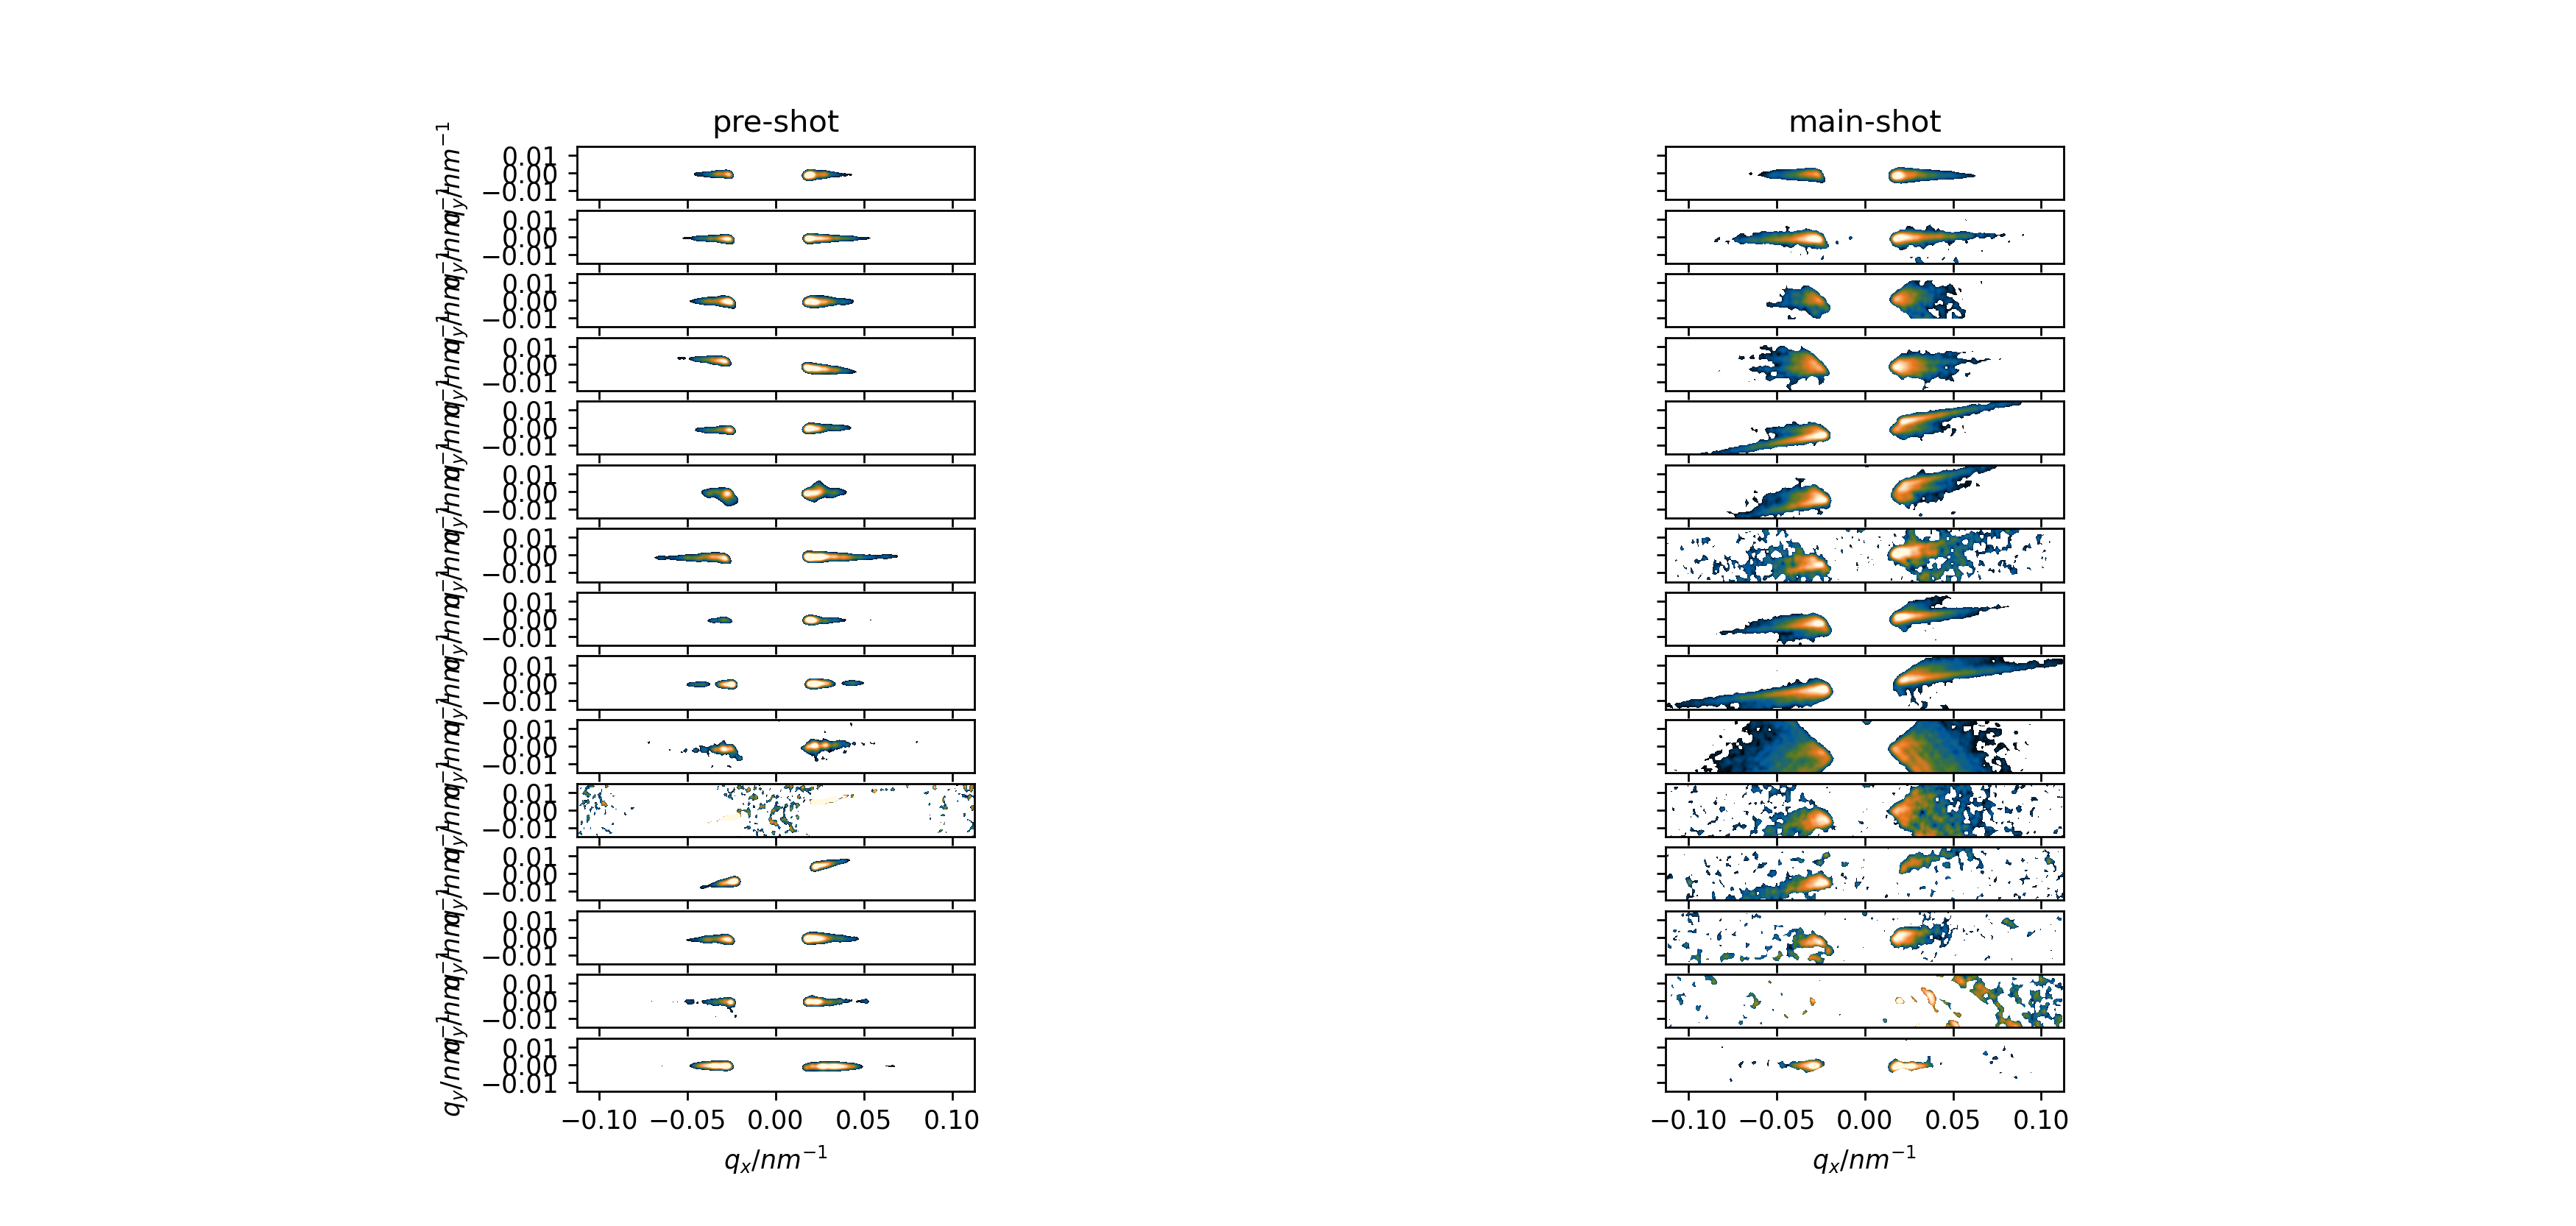

/tmp/ipykernel_22534/786345776.py:91: RuntimeWarning: divide by zero encountered in log
  ef = np.log(ef)[int(dim[0]/2)-40:int(dim[0]/2)+40,:]
/tmp/ipykernel_22534/786345776.py:91: RuntimeWarning: invalid value encountered in log
  ef = np.log(ef)[int(dim[0]/2)-40:int(dim[0]/2)+40,:]
/tmp/ipykernel_22534/786345776.py:92: RuntimeWarning: invalid value encountered in less
  ef[np.where(ef < -2)]=ef[np.where(ef < -2)]/0
/tmp/ipykernel_22534/786345776.py:92: RuntimeWarning: divide by zero encountered in true_divide
  ef[np.where(ef < -2)]=ef[np.where(ef < -2)]/0
/tmp/ipykernel_22534/786345776.py:126: RuntimeWarning: divide by zero encountered in log
  ef = np.log(ef)
/tmp/ipykernel_22534/786345776.py:126: RuntimeWarning: invalid value encountered in log
  ef = np.log(ef)
/tmp/ipykernel_22534/786345776.py:127: RuntimeWarning: invalid value encountered in less
  ef[np.where(ef < -2)]=ef[np.where(ef < -2)]/0
/tmp/ipykernel_22534/786345776.py:127: RuntimeWarning: divide by zero encountered in 

In [32]:
#def gauss(q,a,r,sig,c,q0):
#    return np.log(np.abs(a)/np.abs(q-q0)**np.abs(r)*np.exp(-q**2*sig**2)+c)
def gaussLog(q,a,r,sig,c,q0):
    m=sig*1
    sig=0
    core = np.exp(a)/np.abs(q-q0)**r*np.exp(-q**2*0*(10**sig)**2)+c+m*q
    #core[(core < 0)] = 1e-99
    return np.log(core)

def gauss(q,a,r,sig,c,q0):
    m=sig*1
    sig=0
    core = np.exp(a)/np.abs(q-q0)**r*np.exp(-q**2*0*(10**sig)**2)+c+m*q
    #core[(core < 0)] = 1e-99
    return (core)

#drehen und plotten:
from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from numpy import inf
cmap = rofl.cmap()
cmap.set_under('white')

def fit_func(q,a,r,sig,c,q0):
    if r<2: r=2
    if r>3: r=3
    q=np.abs(q-q0)
    lg = 1/(q)**r*a*np.exp(-(q)**2*sig**2)+c
    lg[np.where(lg==0)] = 1e-9
    gauss = np.log(lg)
    return gauss# + line 

def fit_funcM(q,a,r,sig,c):
    if r<2: r=2
    if r>2: r=2
    q=np.abs(q)
    gauss = np.log(1/(q)**r*a*np.exp(-(q)**2*sig**2)+c)
    return gauss# + line 

def get_angle(ef_):
    pos = list(range(110,220))+list(range(350,460))# [230,250,270,300,320,450,470,500,520,540]
    angle=0
    for pi, x in enumerate(pos):
        a = np.average(ef_[:,x:x+10], axis = 1)
        m = np.where(a == np.max(a))[0] #where is max?
        initial_guess1=np.asarray([np.max(a),m,3,20]).astype(float)
        initial_guess2=np.asarray([np.max(a),m,3,20,0]).astype(float)
        x_ = np.arange(len(a))
        try:
            po,po_cov=curve_fit(fit_func1,x_,a,initial_guess1)
        except:
            po,po_cov=curve_fit(fit_func1,x_,a,initial_guess1)
        m=po[1]
        if pi > 0:
            angle += np.arctan((m2-m)/(pos[pi]-pos[pi-1]))
        m2 = m
    angle /= len(pos)-1
    return angle#[0]

fig,ax=plt.subplots(15,2,sharex=True,sharey=True,figsize=(14,8/18*15))

i=-1
dq = 0.000375546708
qy = np.arange(-40,40)*dq
qx = np.arange(-300,300)*dq

for i,run in enumerate(runs):
    e=0
    for event,event_ in enumerate(runs[run][0:-2]):
        en = runs[run][event]/transmissions[run][event] - runs[run][-1]/transmissions[run][-1]
        try:
            e += en
        except:
            e = en
    bg=np.average(e[10:100,600:900])
    ef = e[30-4:150-4,800:1400]-bg
    el = e[30-4:150-4,0:2200]-bg

    try:
        angle = get_angle(ef)
    except:
        angle = -0.4/180*np.pi#get_angle(ef)
    ef = rotate(ef,angle=-angle/np.pi*180)
    el = rotate(el,angle=-angle/np.pi*180)
    ef /= np.max(np.average(ef,axis=0)) 
    dim = [np.size(ef[:,1]),np.size(ef[1,:])]       

    ef /= np.max(np.average(ef,axis=0))     
    if run==217: ef_217 = np.log(ef)[int(dim[0]/2)-60:int(dim[0]/2)+60,:]
    ef = np.log(ef)[int(dim[0]/2)-40:int(dim[0]/2)+40,:]
    ef[np.where(ef < -2)]=ef[np.where(ef < -2)]/0
    ax[i,0].imshow(ef, cmap=cmap,vmin=0, vmax=2,extent=np.asarray([-300*dq,300*dq,-40*dq,40*dq]))
    ax[0,0].set_title("pre-shot")

    event=-2
    e = runs[run][event]/transmissions[run][event] - runs[run][-1]/transmissions[run][-1]
    bg=0
    ef = (e - bg)[30-4:150-4,800:1400]
    el = e[30-4:150-4,0:2200]-bg
    if delay[run] == 20:
        ef = (e - bg)[60:120,800:1400]
    ef = rotate(ef,angle=-angle/np.pi*180)
    ef /= np.max(np.average(ef,axis=0))
    dim = [np.size(ef[:,1]),np.size(ef[1,:])]


    angle_pre = angle
    if run==217: 
        angle=13.2/180*np.pi
    else:
        if run==219: 
            angle=1/180*np.pi
        else:
            if run==220: 
                angle=1/180*np.pi
            else:
                if run==235: 
                    angle=6/180*np.pi
                else:
                    if run==229:
                        angle=3/180*np.pi
                    else:
                        angle = 0

    ef = np.log(ef)
    ef[np.where(ef < -2)]=ef[np.where(ef < -2)]/0
    if delay[run] == 20:
        ef_ = ef*1.
        ef = np.zeros((80,600))/0
        ef[10:70,:] = ef_[int(dim[0]/2)-30:int(dim[0]/2)+30,0:609]
    else:
        ef = ef[int(dim[0]/2)-40:int(dim[0]/2)+40,:]
    ax[i,1].imshow(ef, cmap=cmap, vmin=-2, vmax=2,extent=np.asarray([-300*dq,300*dq,-40*dq,40*dq]))

    ax[0,1].set_title("main-shot")# | delay: "+str(delay[run])+" ps")
    ax[i,0].set_ylabel("$q_y/nm^{-1}$")
    ax[i,1].annotate(str(delay[run])+" ps",
                         xy=(230, 15), xycoords='data',fontsize=15,
                         horizontalalignment='left', verticalalignment='bottom')
ax[i,0].set_xlabel("$q_x/nm^{-1}$")
ax[i,1].set_xlabel("$q_x/nm^{-1}$")
fig.tight_layout()
plt.show()